In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('pharma_forecasting_dummy_custom_500.xlsx')

In [7]:
np.random.seed(42)

In [9]:
df['Quarter'] = np.random.choice([1,2,3,4], size= len(df))

In [11]:
df['Quarter']

0      3
1      4
2      1
3      3
4      3
      ..
495    3
496    3
497    4
498    1
499    4
Name: Quarter, Length: 500, dtype: int32

In [13]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + 'Q' + df['Quarter'].astype(str))
df = df.sort_values('Date')

In [15]:
df

,Year,Country,Product Name,Dosage Form,Manufacturer,Price (USD),Units,Market / Channel,Sales (USD),Quarter,Date
131,2023,Brazil,DrugB,Injection,AstraZeneca,394.43,116,Retail,45753.88,1,2023-01-01
384,2023,USA,DrugB,Capsule,Sanofi,298.35,95,Hospital,28343.25,1,2023-01-01
276,2023,Japan,DrugD,Injection,Sanofi,190.64,88,Retail,16776.32,1,2023-01-01
228,2023,Germany,DrugA,IV Infusion,Pfizer,384.06,137,Hospital,52616.22,1,2023-01-01
31,2023,Germany,DrugB,Capsule,AstraZeneca,494.43,154,Hospital,76142.22,1,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
197,2025,Japan,DrugA,Syrup,AstraZeneca,225.38,130,Hospital,29299.40,4,2025-10-01
24,2025,USA,DrugD,Tablet,Roche,112.32,163,Retail,18308.16,4,2025-10-01
55,2025,Brazil,DrugC,Syrup,Sanofi,127.84,192,Hospital,24545.28,4,2025-10-01
201,2025,Brazil,DrugB,Syrup,Roche,437.35,186,Retail,81347.10,4,2025-10-01


In [17]:
filtered_df = df[(df['Country'] == 'Germany') & (df['Product Name'] == 'DrugC')]

In [19]:
time_series = filtered_df.groupby('Date')['Sales (USD)'].sum()

In [21]:
time_series

Date
2023-01-01     21146.40
2023-04-01     15742.50
2023-07-01     47357.51
2023-10-01     75618.58
2024-01-01     78791.44
2024-04-01    238759.59
2024-07-01     61126.26
2024-10-01     79661.56
2025-01-01    154330.38
2025-04-01     25220.12
2025-07-01     83513.59
2025-10-01     20659.00
Name: Sales (USD), dtype: float64

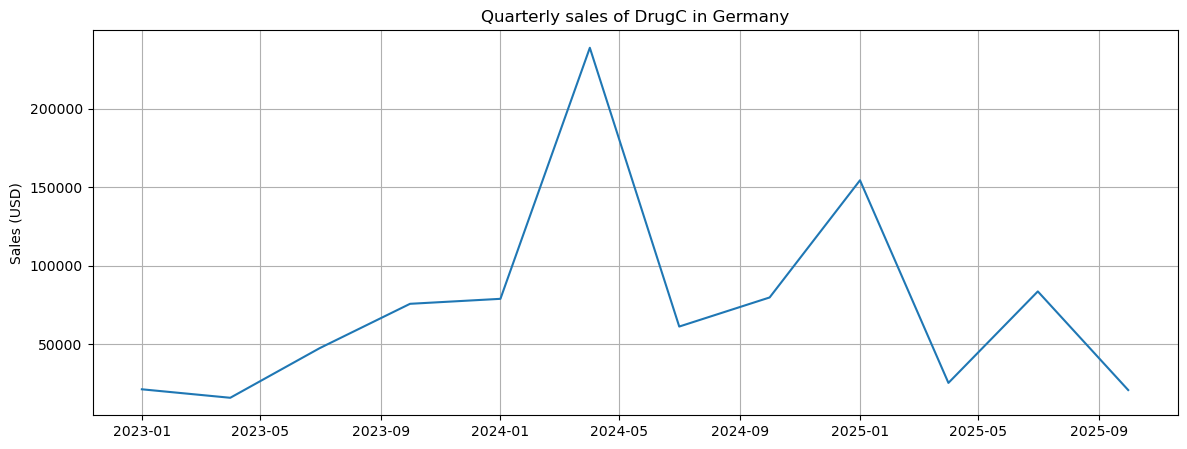

In [23]:
plt.figure(figsize=(14,5))
plt.plot(time_series)
plt.title('Quarterly sales of DrugC in Germany')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.show()

In [25]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('P-value', result[1])
    print('Critical values: ')
    for key, value in result[4].items():
        print(f'\t{key}:{value}')

In [27]:
print('origincal Series')
adf_test(time_series)

origincal Series
ADF Statistic: -3.1160962041913423
P-value 0.02538470311593859
Critical values: 
	1%:-4.223238279489106
	5%:-3.189368925619835
	10%:-2.729839421487603


In [29]:
#Differencing table

ts_diff = time_series - time_series.shift(1)
ts_diff = ts_diff.dropna()

In [31]:
print('After making differncing')
adf_test(ts_diff)

After making differncing
ADF Statistic: -5.361019912067923
P-value 4.087853340887203e-06
Critical values: 
	1%:-4.331573
	5%:-3.23295
	10%:-2.7487


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 5.

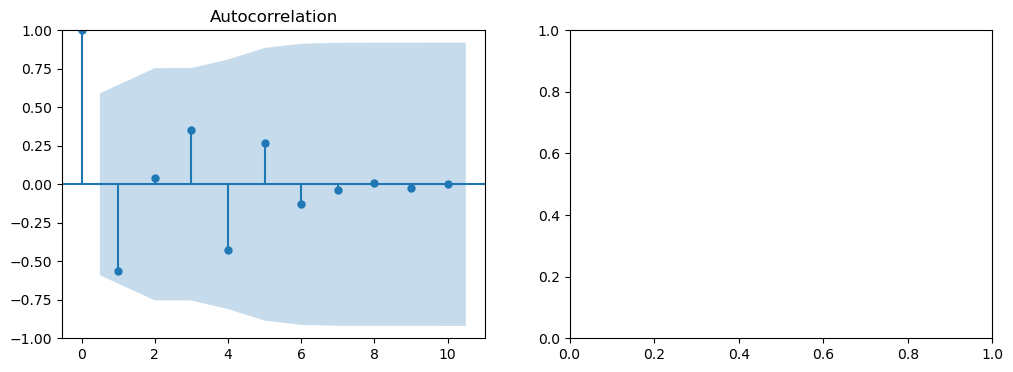

In [33]:
max_lags = min(20, len(ts_diff) - 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts_diff, lags=max_lags, ax=axes[0])
plot_pacf(ts_diff, lags=max_lags, ax=axes[1], method='ywm')

In [35]:
#Building and also evaluating the ARIMA Model

In [39]:
train_size = int(len(time_series) * 0.8)
train = time_series[:train_size]
test = time_series[train_size:]

In [41]:
train_size = int(len(time_series) * 0.8)

In [43]:
train_size

9

In [45]:
#Entering 80% data
train = time_series[:train_size]

In [47]:
train

Date
2023-01-01     21146.40
2023-04-01     15742.50
2023-07-01     47357.51
2023-10-01     75618.58
2024-01-01     78791.44
2024-04-01    238759.59
2024-07-01     61126.26
2024-10-01     79661.56
2025-01-01    154330.38
Name: Sales (USD), dtype: float64

In [49]:
#Entering 20% data
test = time_series[train_size:]

In [51]:
test

Date
2025-04-01    25220.12
2025-07-01    83513.59
2025-10-01    20659.00
Name: Sales (USD), dtype: float64

In [53]:
model = ARIMA(train, order = (1,1,1))
model_fit = model.fit()

In [55]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Sales (USD)   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -101.786
Date:                Tue, 23 Sep 2025   AIC                            209.572
Time:                        16:34:39   BIC                            209.810
Sample:                    01-01-2023   HQIC                           207.965
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2305      1.433     -0.161      0.872      -3.039       2.578
ma.L1         -0.4289      1.105     -0.388      0.698      -2.595       1.737
sigma2      1.028e+10   2.02e-10   5.08e+19      0.0

In [59]:
# Forecast for the test period

forecast = model_fit.get_forecast(steps = len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [61]:
forecast_values

2025-04-01    112606.412426
2025-07-01    122222.031523
2025-10-01    120006.035873
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [63]:
confidence_intervals

,lower Sales (USD),upper Sales (USD)
2025-04-01,-86119.258250,311332.083101
2025-07-01,-87716.335086,332160.398132
2025-10-01,-111632.783417,351644.855164


In [65]:
rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f'\nRoot Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 79591.7522650834


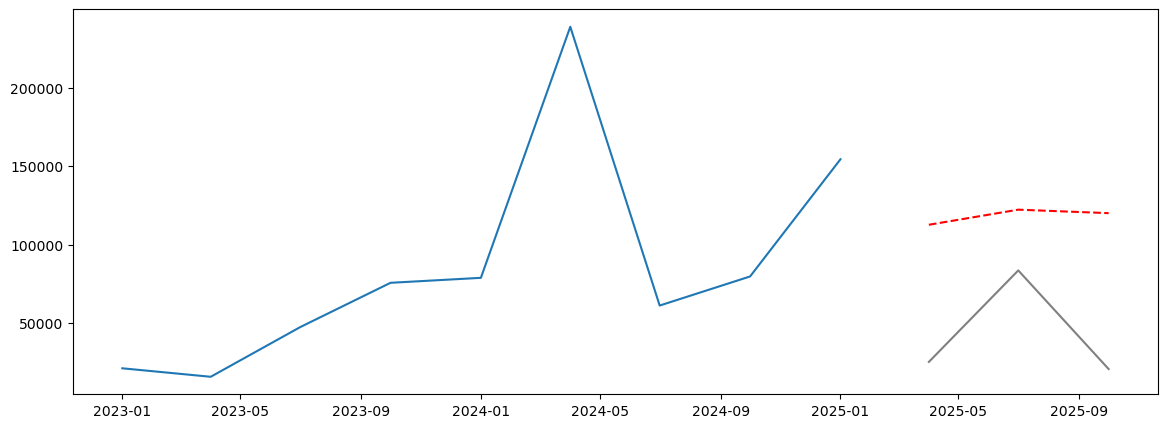

In [67]:
plt.figure(figsize= (14,5))
plt.plot(train.index, train, label = 'Training data')
plt.plot(test.index, test, label = 'Actual Sales', color = 'gray')
plt.plot(test.index, forecast_values, label = 'Forecast', color = 'red', linestyle = '--')

In [69]:
rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f'\nRoot Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 79591.7522650834


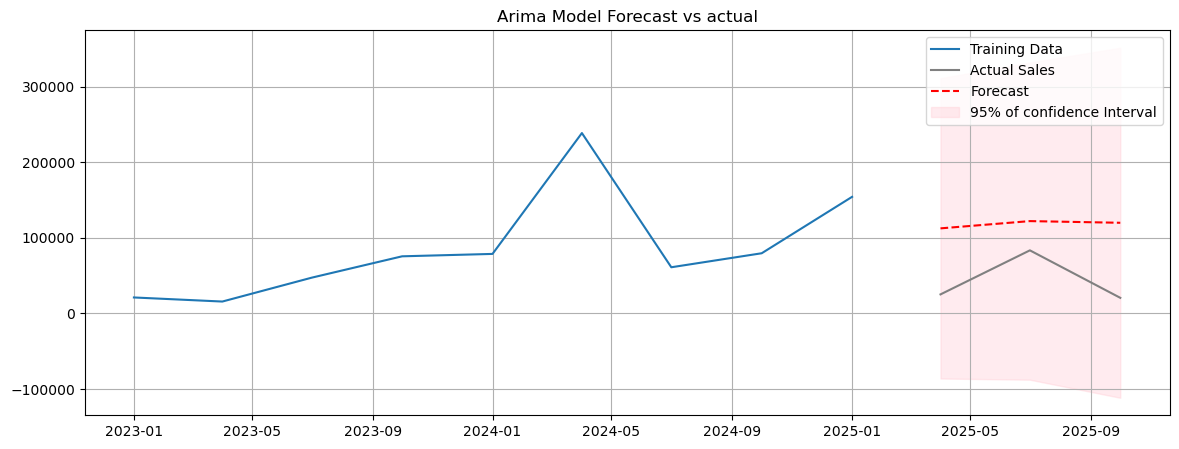

In [71]:
plt.figure(figsize= (14,5))
plt.plot(train.index, train, label = 'Training Data')
plt.plot(test.index, test, label = 'Actual Sales', color = 'gray')
plt.plot(test.index, forecast_values, label = 'Forecast', color = 'red', linestyle = '--')
plt.fill_between(test.index,
                 confidence_intervals.iloc[:,0],
                 confidence_intervals.iloc[:,1],
                 color = 'pink', alpha = 0.3, label = '95% of confidence Interval')
plt.title('Arima Model Forecast vs actual')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
#Fit the model on the complete dataset

final_model = ARIMA(time_series, order = (1,1,1))
final_model_fit = final_model.fit()

# Next for the next 4 quarters (means 1 year)

future_forecast_steps = 4
future_forecast = final_model_fit.get_forecast(steps= future_forecast_steps)
future_forecast_values = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()


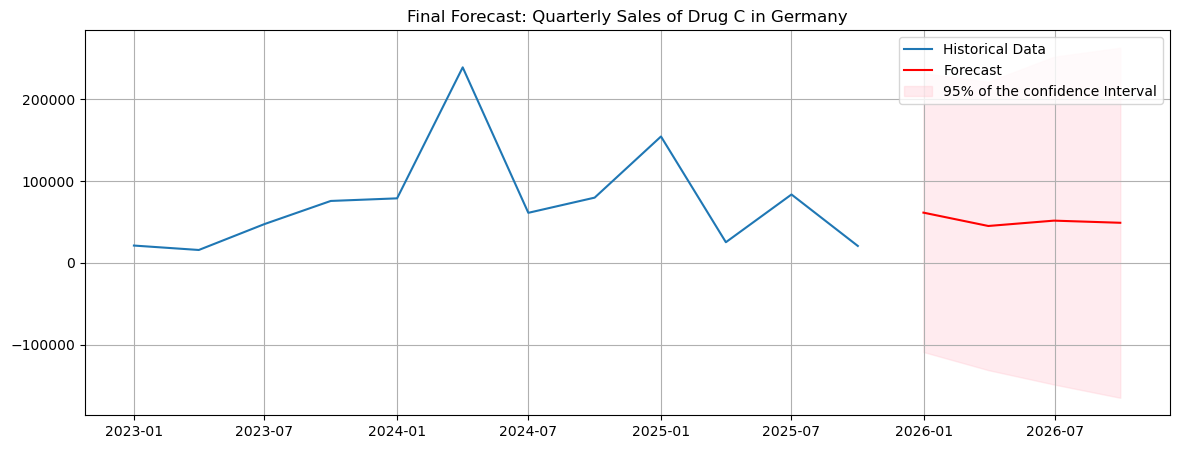

                 Date  Forecast Sales (USD)   Lower CI   Upper CI
2026-01-01 2025-12-31              61344.19 -108847.96  231536.33
2026-04-01 2026-03-31              45048.06 -130983.10  221079.23
2026-07-01 2026-06-30              51575.34 -148512.59  251663.28
2026-10-01 2026-09-30              48960.89 -164732.41  262654.20


In [75]:
#Create a date index for the future period
last_date = time_series.index[-1]
future_dates = pd.date_range(start= last_date + pd.offsets.QuarterEnd(1), periods= future_forecast_steps, freq= 'Q')

# Plot the final forecast
plt.figure(figsize=(14,5))
plt.plot(time_series.index, time_series, label = 'Historical Data')
plt.plot(future_dates, future_forecast_values, label = 'Forecast', color = 'red')
plt.fill_between(future_dates,
                 future_conf_int.iloc[:,0],
                 future_conf_int.iloc[:,1],
                 color = 'pink', alpha = 0.3, label = '95% of the confidence Interval')
plt.title('Final Forecast: Quarterly Sales of Drug C in Germany')
plt.legend()
plt.grid(True)
plt.show()

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast Sales (USD)': future_forecast_values,
    'Lower CI':future_conf_int.iloc[:, 0],
      'Upper CI' : future_conf_int.iloc[:,1]
})

print(forecast_df.round(2))